In [40]:
import os
from typing import TypedDict, Annotated, List, Dict
import gradio as gr
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from IPython.display import Image, display
import fitz

In [41]:
memory = InMemorySaver()
class State(TypedDict):
    """
    The state for our LangGraph agent.
    """
    # documents: List[str] # List of document identifiers
    chat_history: List[Dict[str, str]]
    query: str
    response: str
    document: str
    extracted_text: str
    # is_inter_document_query: bool

In [42]:
load_dotenv(override=True)

GEMINI_BASE_URL = os.getenv("GEMINI_BASE_URL")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
llm = init_chat_model("google_genai:gemini-2.0-flash")

In [43]:
def llm_generation(state: State):
    """
    Simulates a call to the Bedrock LLM to generate a final response.
    """
    print("---NODE : LLM GENERATION---")
    print(state)
    print(state["extracted_text"])
    response_prompt = state["extracted_text"]
    prompt = f"Based on the following context: '{response_prompt}', answer the user's query: '{state['query']}'"
    # prompt = state["query"]
    final_response = llm.invoke(prompt)
    
    # Update chat history and return the final response
    chat_history = state.get("chat_history", [])
    chat_history.append({"user": state["query"], "assistant": final_response})
    
    return {"response": final_response, "chat_history": chat_history}

def context_generation(state: State):
    """
    Node to extract text from PDF bytes.
    """
    print("---NODE: PDF TEXT EXTRACTION---")
    print(state)
    
    file_bytes = state.get("document")
    if not file_bytes:
        raise ValueError("No file bytes found in state")
    
    pdf_text = ""
    with fitz.open(stream=file_bytes, filetype="pdf") as doc:
        for page in doc:
            pdf_text += page.get_text()
    # print(pdf_text)
    # Add extracted text to state
    return {
        # **state,  # Keep previous state keys
        "extracted_text": pdf_text,
        "document": None
    }

def should_extract(state):
    """Condition function: returns next node name based on state."""
    print(state)
    if state.get("document"):  # already has text
        return "extraction"

    return "generation"

In [44]:
memory = InMemorySaver()
workflow = StateGraph(State)

workflow.add_node("generation", llm_generation)
workflow.add_node("extraction", context_generation)

workflow.add_conditional_edges(
    START,
    should_extract,
    {
        "extraction": "extraction",  # go to extraction if no text
        "generation": "generation"   # skip extraction if already done
    }
)
# workflow.add_edge("extraction", "generation")
workflow.add_edge("generation", END)

graph = workflow.compile(checkpointer=memory)

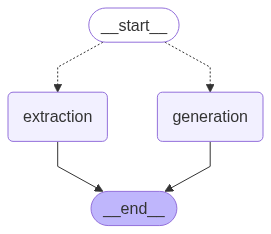

In [45]:
display(Image(graph.get_graph().draw_mermaid_png(max_retries=3, retry_delay=5)))

In [50]:
# --- Gradio UI Functions ---
session_id = "user-session-1"
config = {"configurable": {"thread_id": "1"}}

initial_state = {
    "document": None,
    "chat_history": [],
    "query": "",
    "response": "",
    "extracted_text": ""
}

graph.update_state(config, values=initial_state, task_id=session_id)

def process_document(file):
    """Function to handle document upload and ingestion."""
    if file is None:
        return "Please upload a document first."
    
    # Read file bytes
    with open(file.name, "rb") as f:
        file_bytes = f.read()
    

    current_state = graph.get_state(config)
    state_dict = dict(current_state.values)

    # Now you can modify it
    state_dict["document"] = file_bytes
    state_dict["query"] = os.path.basename(file.name)

    # Invoke the graph with the updated dict
    text = graph.invoke(state_dict, config)
    # Persist updated state
    # graph.update_state(config, values=state_dict, task_id=session_id)
    return "Successfully Extracted and Processed Document"
    # Assuming the graph node returns extracted text or some processed response
    # return True

def chat_interface(query, history):
    """Function to handle user chat messages."""

    current_state = graph.get_state(config)
    
    state_dict = dict(current_state.values)

    # Now you can modify it
    state_dict["query"] = query
    
    graph_state = graph.invoke(state_dict, config)

    # graph.update_state(config, values=graph_state, task_id=session_id)
    
    # Extract the AIMessage object from the "response" key
    ai_message = graph_state.get("response")

    if hasattr(ai_message, "content"):
        return ai_message.content
    elif isinstance(ai_message, dict) and "content" in ai_message:
        return ai_message["content"]
    else:
        return str(ai_message)

# Create the Gradio interface using gr.Blocks for flexibility
with gr.Blocks(title="LangGraph Document Agent") as demo:
    gr.Markdown("# LangGraph Document Agent")
    gr.Markdown("Upload documents to ingest them, then chat with the agent.")
    
    with gr.Row():
        # file_upload = gr.File(label="Upload Document")
        file_upload = gr.File(
        label="Upload Documents",
        file_count="multiple"
        # file_types=[".pdf", ".docx", ".txt"],  # Optional: restrict file types
        )
        process_button = gr.Button("Process Document")
    
    ingestion_output = gr.Textbox(label="Document Processing Status")

    process_button.click(
        fn=process_document,
        inputs=file_upload,
        outputs=ingestion_output
    )

    chatbot = gr.ChatInterface(
        fn=chat_interface,
        examples=["What is the content of document1.txt?", "Compare the names across all documents.", "How is document2.pdf different from document3.docx?"]
    )

# Launch the Gradio app
demo.launch()

c:\Users\PratikTalaviya\Crest-Projects\Document-Processing-Agent\.venv\Lib\site-packages\gradio\chat_interface.py:345: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7896
* To create a public link, set `share=True` in `launch()`.
